In [9]:
%matplotlib inline

import os
import h5py
import pandas as pd
import numpy as np
import pickle as pkl
import time
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras

# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)
    print(os.getcwd())

import functions_metrics as fm
import functions_model_definition as md
import functions_read_data as rdat
import Utils_maurice as utils
import ens_weights_tuning as w_tune

#ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc, ontram_auc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters

/tf/notebooks/schnemau/xAI_stroke_3d
/tf/notebooks/schnemau/xAI_stroke_3d


In [10]:
version = "10Fold_CIBLSX_noTIA" 
layer_connection = "globalAveragePooling" 
last_activation = "linear" 
# Define Model Version
model_version = 1

# should csv be saved?
save_file = True

DATA_OUTPUT_DIR = DIR + "data/"

# Setup the paths for the result assembly
DATA_DIR = DIR + "data/" 
WEIGHT_DIR = DIR + "weights/" + version + "/"
#id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V0.csv", sep=",")
id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V3_mhs.csv", sep=",")
X = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")
all_result_name = "all_tab_results_" + version + "_M" + str(model_version)
which_splits = list(range(0,10)) # 10 Fold
print(id_tab.shape)
print(X.shape)

print(WEIGHT_DIR)
print(all_result_name)

(295, 14)
(407, 128, 128, 28)
/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX_noTIA/
all_tab_results_10Fold_CIBLSX_noTIA_M1


In [11]:
#only load this data_loader for X_tab_train
(X_train, X_valid, X_test),(X_tab_train, X_tab_valid, X_tab_test), (y_train, y_valid, y_test) = rdat.split_data_tabular(id_tab, X, 1)

input_dim = (128, 128, 28, 1)
output_dim = 1
batch_size = 6
C = 2 

mbl = utils.img_model_linear_final(input_dim, output_dim)
mls = utils.mod_linear_shift(X_tab_train.shape[1])
model_3d = ontram(mbl, mls)             

model_3d.compile(optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
                                loss=ontram_loss(C, batch_size),
                                metrics=[ontram_acc(C, batch_size)])

model_nrs = list(range(5))

In [12]:
results_list = [] # test dataset results
valid_list = [] # validation datset results
betas = [] # validation datset results

for which_split in which_splits:
    (X_train, X_valid, X_test),(X_tab_train, X_tab_valid, X_tab_test), (y_train, y_valid, y_test) = rdat.split_data_tabular(id_tab, X, which_split)

    X_train = np.expand_dims(X_train, axis=-1)
    X_valid = np.expand_dims(X_valid, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)
    Y_train = to_categorical(y_train)
    Y_valid = to_categorical(y_valid)
    Y_test = to_categorical(y_test)
        
    test_data = tf.data.Dataset.from_tensor_slices((X_test, X_tab_test))
    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))
    test_dataset_pred = (test_loader.batch(len(X_test)))

    valid_data = tf.data.Dataset.from_tensor_slices((X_valid, X_tab_valid))
    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))
    valid_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    valid_dataset_pred = (valid_loader.batch(len(X_valid)))  
  
    results = id_tab[id_tab["fold" + str(which_split)] == "test"].copy()      
        
    results["test_split"] = which_split        
    
    validation_results = pd.DataFrame(
        {"test_split": which_split,
         "unfavorable": y_valid}
    )
       
    shift_params = []
    intercepts_test = []
    intercepts_val = []
    y_test_preds = []
    y_valid_preds = []
   
    for model_nr in model_nrs:        
        model_name = ("/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX_noTIA/3d_cnn_binary_model_split" + "CIB_LSX" + str(which_split) + 
                          "_normalized_avg_layer_paper_model_" + last_activation + 
                          "_activation_" + str(model_version) + "_" + str(model_nr) + ".h5")        
        
        model_3d.load_weights(model_name)
        
        #test
        predic =  predict_ontram(model_3d, data = test_dataset_pred)['pdf'][:,1]
        y_test_preds.append(predic.squeeze())
        results["y_pred_model_" + str(model_nr)] = y_test_preds[-1]

        #valid
        predicc = predict_ontram(model_3d, data = valid_dataset_pred)['pdf'][:,1]
        y_valid_preds.append(predicc.squeeze())
        validation_results["y_pred_model_" + str(model_nr)] = y_valid_preds[-1]   

        #ensembling        
        shift_params.append(get_parameters(model_3d)['shift'][0][0][0])
        #test
        preds_test = model_3d.predict(test_dataset_pred)
        intercepts_test.append(preds_test[:, 0])
        #valid
        preds_val = model_3d.predict(valid_dataset_pred)
        intercepts_val.append(preds_val[:, 0])

    
    y_test_preds = np.array(y_test_preds)
    y_valid_preds = np.array(y_valid_preds)

    #first optimize weights based on validation set
    weigths_tuned = w_tune.get_w(intercepts = intercepts_val, shift = shift_params, 
                                 X_tab = X_tab_valid, y_true = y_valid, nens = 5)
    
    #calculate ensemble based on optimized weights

    w_tune.get_ensemble(intercepts_val, shift_params, X_tab_valid, weights=weigths_tuned, n_ens=5)

    results["y_pred_trafo_avg"] = w_tune.get_ensemble(intercepts_test, shift_params, X_tab_test, weights=weigths_tuned, n_ens=5)
    validation_results["y_pred_trafo_avg"] = w_tune.get_ensemble(intercepts_val, shift_params, X_tab_valid, weights=weigths_tuned, n_ens=5)

#    results["y_pred_trafo_avg"] = w_tune.get_ensemble(intercepts_test, shift_params, X_tab_test, weights=None, n_ens=5)
#    validation_results["y_pred_trafo_avg"] = w_tune.get_ensemble(intercepts_val, shift_params, X_tab_valid, weights=None, n_ens=5)
    
    results_list.append(results)
    valid_list.append(validation_results)

 
---- Split 0 ----
 
Optimal Geometric Mean Threshold: 0.12573535773111
Accuracy to beat: 0.7586206896551724
Accuracy: 0.7931034482758621
Spezifität:  0.7272727272727273
Sensitivität:  1.0


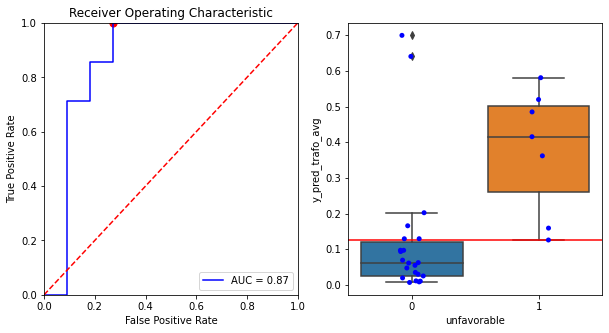

 
---- Split 1 ----
 
Optimal Geometric Mean Threshold: 0.2797072283750248
Accuracy to beat: 0.7586206896551724
Accuracy: 0.8620689655172413
Spezifität:  0.8181818181818181
Sensitivität:  1.0


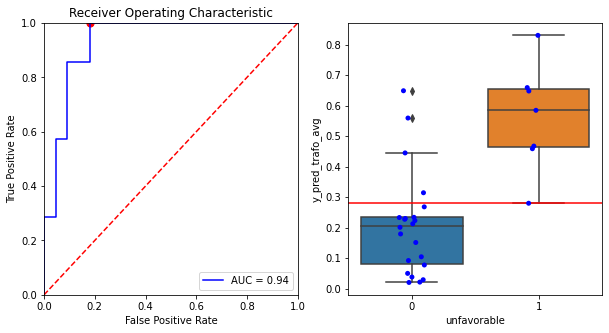

 
---- Split 2 ----
 
Optimal Geometric Mean Threshold: 0.4206812099849754
Accuracy to beat: 0.7586206896551724
Accuracy: 0.896551724137931
Spezifität:  1.0
Sensitivität:  0.5714285714285714


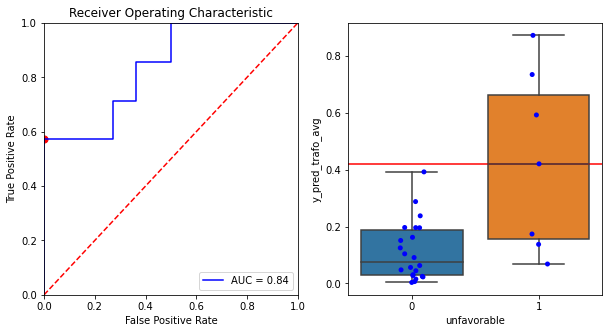

 
---- Split 3 ----
 
Optimal Geometric Mean Threshold: 0.11761458190769047
Accuracy to beat: 0.7586206896551724
Accuracy: 0.6551724137931034
Spezifität:  0.5454545454545454
Sensitivität:  1.0


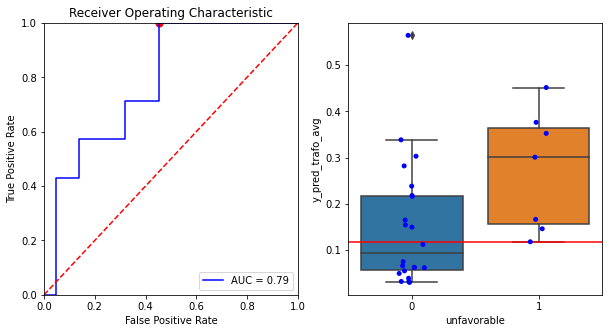

 
---- Split 4 ----
 
Optimal Geometric Mean Threshold: 0.2678362112380491
Accuracy to beat: 0.7586206896551724
Accuracy: 0.7586206896551724
Spezifität:  0.8181818181818181
Sensitivität:  0.5714285714285714


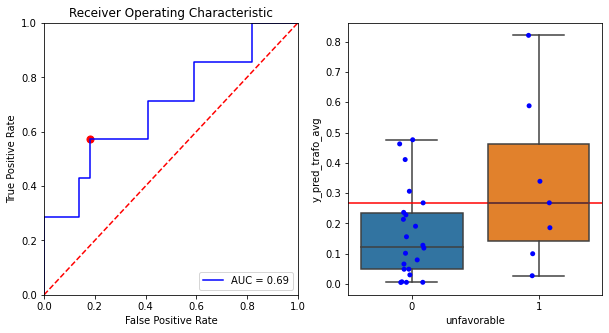

 
---- Split 5 ----
 
Optimal Geometric Mean Threshold: 0.15202551440707424
Accuracy to beat: 0.7666666666666666
Accuracy: 0.7
Spezifität:  0.6086956521739131
Sensitivität:  1.0


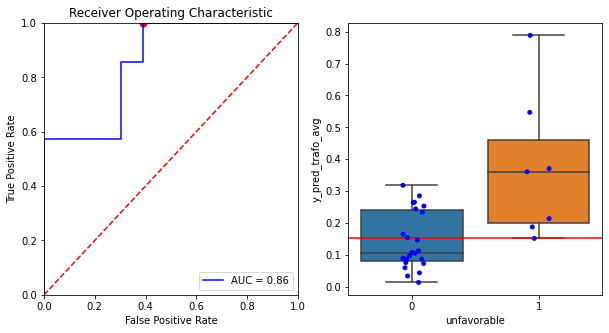

 
---- Split 6 ----
 
Optimal Geometric Mean Threshold: 0.3326789165311296
Accuracy to beat: 0.7666666666666666
Accuracy: 0.8666666666666667
Spezifität:  0.8695652173913043
Sensitivität:  0.8571428571428571


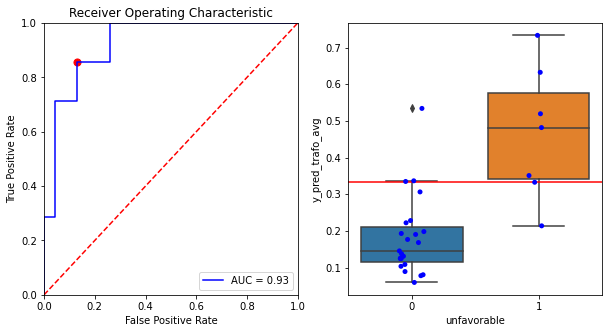

 
---- Split 7 ----
 
Optimal Geometric Mean Threshold: 0.20086047752929315
Accuracy to beat: 0.7666666666666666
Accuracy: 0.7666666666666667
Spezifität:  0.7391304347826086
Sensitivität:  0.8571428571428571


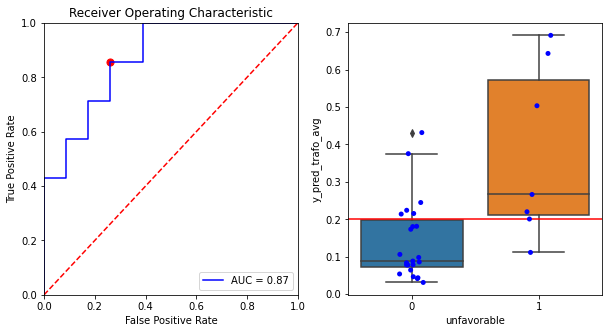

 
---- Split 8 ----
 
Optimal Geometric Mean Threshold: 0.10013181656662018
Accuracy to beat: 0.7666666666666666
Accuracy: 0.5333333333333333
Spezifität:  0.3913043478260869
Sensitivität:  1.0


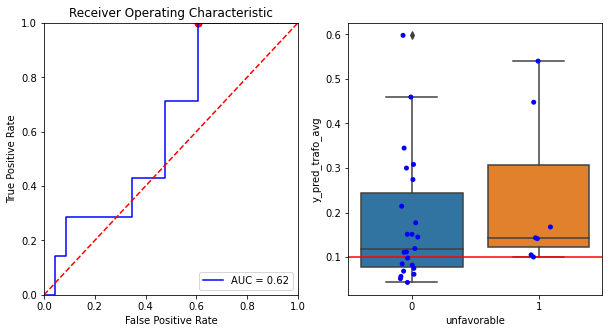

 
---- Split 9 ----
 
Optimal Geometric Mean Threshold: 0.20708243813562732
Accuracy to beat: 0.7666666666666666
Accuracy: 0.8333333333333334
Spezifität:  0.782608695652174
Sensitivität:  1.0


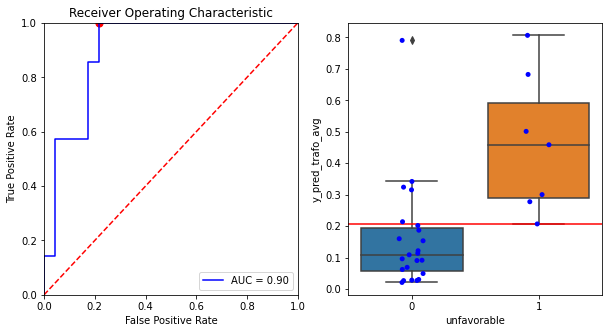

In [13]:
valid_thresholds = []

for i, validation_results in enumerate(valid_list):
    print(" ")
    print("---- Split " + str(which_splits[i]) + " ----")
    print(" ")
    
    y_org = validation_results["unfavorable"]
    y_pred = validation_results["y_pred_trafo_avg"]
    
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    # calculate geometric mean of tpr and fpr to find best threshold
    gmean = np.sqrt(tpr * (1 - fpr))

    # Find the optimal threshold
    index = np.argmax(gmean)
    valid_thresholds.append(threshold[index])
    print("Optimal Geometric Mean Threshold: " + str(threshold[index]))
    
    # Calc Acc
    y_pred_label = (y_pred >= threshold[index]).squeeze()
    print("Accuracy to beat: " + str(1 - np.mean(y_org)))
    print("Accuracy: " + str(np.mean(y_pred_label == y_org)))
          
    print("Spezifität: ", 1-fpr[index])
    print("Sensitivität: ", tpr[index])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    
    # method I: plt
    ax1.title.set_text('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.scatter(fpr[index], tpr[index], color = "red", s = 50)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    sns.boxplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        data = validation_results,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        color = 'blue',
        data = validation_results,
        ax = ax2)
    ax2.axhline(y = threshold[index], color = "red")
    
    plt.show()

### Apply Threshold to Testdata

 
---- Split 0 ----
 
Accuracy to beat: 0.7666666666666666
Accuracy: 0.5333333333333333
Spezifität:  0.4347826086956522
Sensitivität:  0.8571428571428571


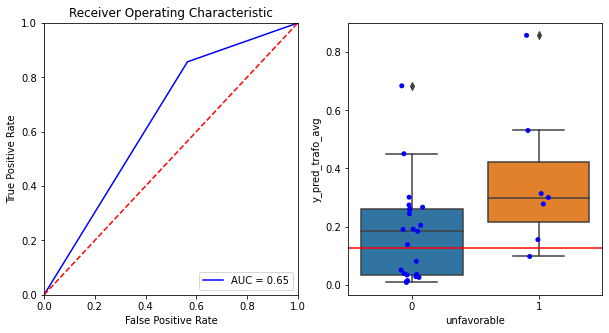

 
---- Split 1 ----
 
Accuracy to beat: 0.7666666666666666
Accuracy: 0.7
Spezifität:  0.782608695652174
Sensitivität:  0.42857142857142855


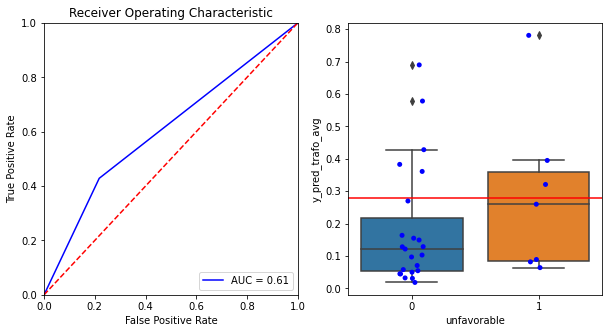

 
---- Split 2 ----
 
Accuracy to beat: 0.7666666666666666
Accuracy: 0.7666666666666667
Spezifität:  0.9130434782608696
Sensitivität:  0.2857142857142857


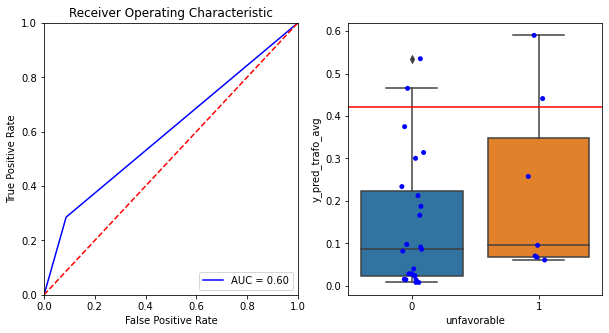

 
---- Split 3 ----
 
Accuracy to beat: 0.7666666666666666
Accuracy: 0.4666666666666667
Spezifität:  0.3913043478260869
Sensitivität:  0.7142857142857143


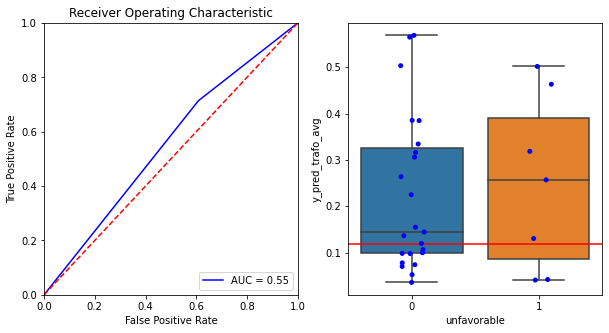

 
---- Split 4 ----
 
Accuracy to beat: 0.7666666666666666
Accuracy: 0.6666666666666666
Spezifität:  0.7391304347826086
Sensitivität:  0.42857142857142855


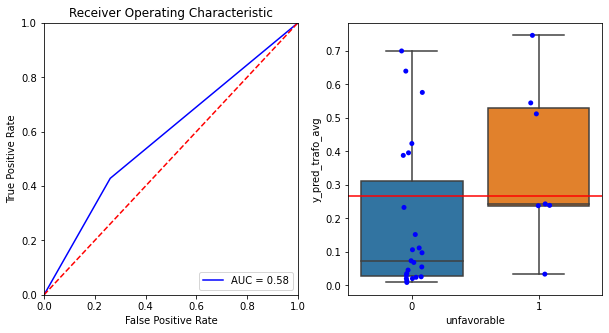

 
---- Split 5 ----
 
Accuracy to beat: 0.7586206896551724
Accuracy: 0.7241379310344828
Spezifität:  0.6818181818181819
Sensitivität:  0.8571428571428571


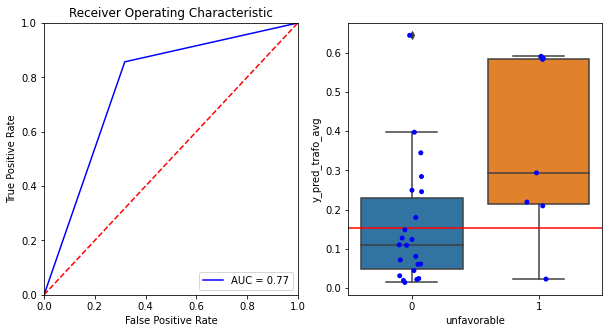

 
---- Split 6 ----
 
Accuracy to beat: 0.7586206896551724
Accuracy: 0.6896551724137931
Spezifität:  0.7272727272727273
Sensitivität:  0.5714285714285714


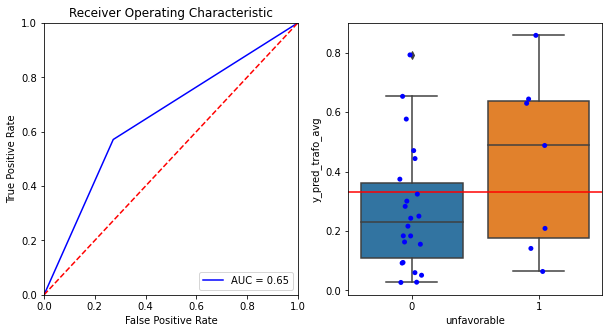

 
---- Split 7 ----
 
Accuracy to beat: 0.7586206896551724
Accuracy: 0.7241379310344828
Spezifität:  0.7272727272727273
Sensitivität:  0.7142857142857143


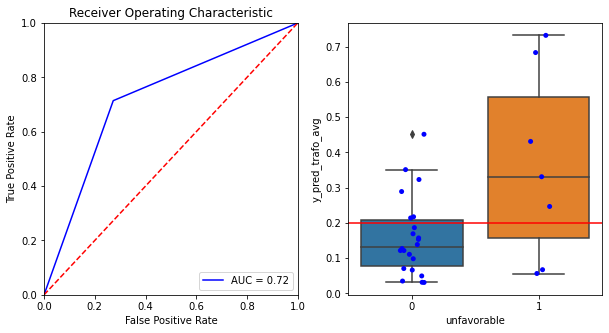

 
---- Split 8 ----
 
Accuracy to beat: 0.7586206896551724
Accuracy: 0.6206896551724138
Spezifität:  0.5454545454545454
Sensitivität:  0.8571428571428571


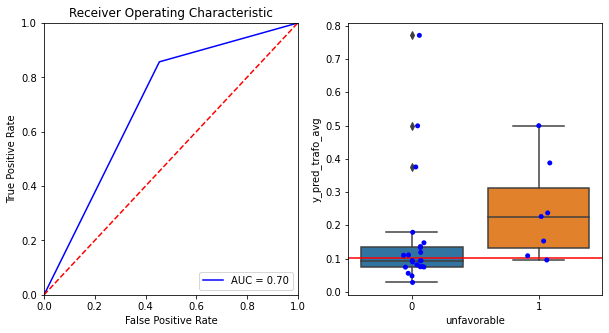

 
---- Split 9 ----
 
Accuracy to beat: 0.7586206896551724
Accuracy: 0.7931034482758621
Spezifität:  0.8181818181818181
Sensitivität:  0.7142857142857143


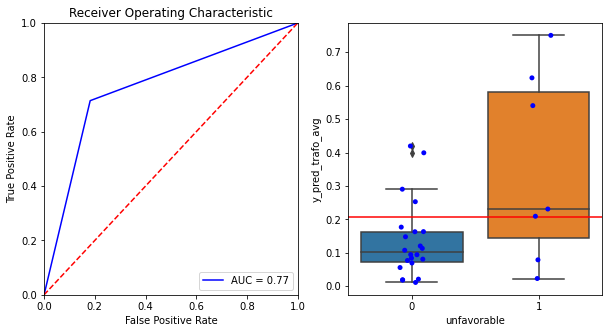

In [14]:
for i, results in enumerate(results_list):
    print(" ")
    print("---- Split " + str(which_splits[i]) + " ----")
    print(" ")

    results["threshold"] = valid_thresholds[i]
    results["y_pred_class"] = (results["y_pred_trafo_avg"] >= results["threshold"]).astype(int)
    
    y_org = results["unfavorable"]
    y_pred = results["y_pred_class"]
    
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
      
    # Calc Acc
    print("Accuracy to beat: " + str(1 - np.mean(y_org)))
    print("Accuracy: " + str(np.mean(y_pred == y_org)))
          
    print("Spezifität: ", 1-fpr[1])
    print("Sensitivität: ", tpr[1])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    
    # method I: plt
    ax1.title.set_text('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    sns.boxplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        data = results,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        color = 'blue',
        data = results,
        ax = ax2)
    ax2.axhline(y = valid_thresholds[i], color = "red")
    
    plt.show()

#### Concat all Pandas and Analyze

In [15]:
all_results = pd.concat(results_list)
all_results.shape
all_results

,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,fold5,...,fold9,test_split,y_pred_model_0,y_pred_model_1,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_trafo_avg,threshold,y_pred_class
4,5,6,3.0,1,test,train,train,train,train,val,...,train,0,0.317742,0.031450,0.157671,0.108253,0.090348,0.155045,0.125735,1
14,15,22,0.0,0,test,train,train,train,train,val,...,train,0,0.043160,0.081941,0.468955,0.050117,0.005942,0.450580,0.125735,1
22,23,32,0.0,0,test,train,train,train,train,val,...,train,0,0.116508,0.147548,0.206775,0.079829,0.091422,0.204504,0.125735,1
30,31,41,0.0,0,test,train,train,train,train,val,...,train,0,0.074973,0.022241,0.050761,0.075406,0.041304,0.050346,0.125735,0
34,35,46,0.0,0,test,train,train,train,train,val,...,train,0,0.019331,0.009849,0.014069,0.011634,0.013404,0.014025,0.125735,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,356,498,1.0,0,train,train,train,train,val,train,...,test,9,0.020192,0.016364,0.016907,0.019493,0.001542,0.011485,0.207082,0
260,362,505,2.0,0,train,train,train,train,val,train,...,test,9,0.055480,0.051987,0.155956,0.080494,0.065137,0.056056,0.207082,0
265,367,510,4.0,1,train,train,train,train,val,train,...,test,9,0.099952,0.094529,0.071210,0.190484,0.031765,0.079088,0.207082,0
275,377,521,0.0,0,train,train,train,train,val,train,...,test,9,0.098031,0.071902,0.107646,0.012211,0.027216,0.069608,0.207082,0


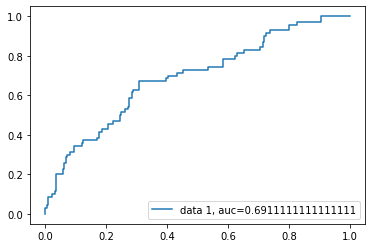

In [18]:
y_test = all_results["unfavorable"]
y_pred_proba = all_results["y_pred_trafo_avg"]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

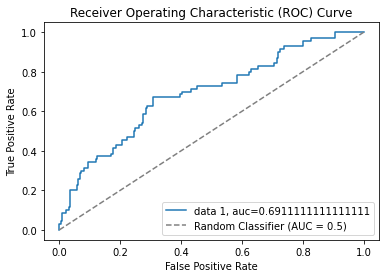

In [20]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming all_results is your DataFrame
y_test = all_results["unfavorable"]
y_pred_proba = all_results["y_pred_trafo_avg"]

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier (AUC = 0.5)')  # Line for random classifier
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()


In [19]:
from sklearn import metrics
import pandas as pd

# Assuming all_results is your DataFrame
y_true = all_results["unfavorable"]
y_pred_binary = all_results["y_pred_class"]
y_pred_trafo_avg = all_results["y_pred_trafo_avg"]

# Calculate metrics
f1_value = metrics.f1_score(y_true, y_pred_binary)
sensitivity = metrics.recall_score(y_true, y_pred_binary)
specificity = metrics.recall_score(y_true, y_pred_binary, pos_label=0)

# Calculate AUC
auc_value = metrics.roc_auc_score(y_true, y_pred_trafo_avg)

# Display results
print("F1-Value:", f1_value)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("AUC:", auc_value)


F1-Value: 0.4787234042553191
Sensitivity: 0.6428571428571429
Specificity: 0.6755555555555556
AUC: 0.6911111111111111


In [17]:
metrics.log_loss(y_true, y_pred_trafo_avg)

0.524864990898865

In [25]:
all_results2 = pd.read_csv("/tf/notebooks/schnemau/xAI_stroke_3d/data/all_tab_results_10Fold_CIBLSX_M1_dyn_threshold.csv")

In [26]:
all_results2

,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,fold5,...,y_pred_model_1,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct
0,14,21,1.0,0,test,train,train,train,train,val,...,0.008706,0.011752,0.004347,0.010668,0.010045,0.195370,0,0.006282,0.012502,True
1,27,36,0.0,0,test,train,train,train,train,val,...,0.066415,0.218940,0.026023,0.091565,0.078780,0.195370,0,0.072822,0.181403,True
2,28,38,2.0,0,test,train,train,train,train,val,...,0.046325,0.092207,0.052394,0.227226,0.071203,0.195370,0,0.079885,0.199330,True
3,34,44,1.0,0,test,train,train,train,train,val,...,0.250173,0.151111,0.181767,0.202023,0.188954,0.195370,0,0.037820,0.092555,True
4,35,46,0.0,0,test,train,train,train,train,val,...,0.018001,0.007016,0.006057,0.006401,0.008405,0.195370,0,0.005010,0.009272,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,345,486,0.0,0,train,train,train,train,val,train,...,0.073613,0.284167,0.183057,0.216218,0.166124,0.219728,0,0.079370,0.198022,True
403,370,514,3.0,1,train,train,train,train,val,train,...,0.065619,0.014339,0.122743,0.017489,0.056816,0.219728,0,0.092784,0.232071,False
404,394,541,0.0,0,train,train,train,train,val,train,...,0.023103,0.035995,0.025119,0.011267,0.025886,0.219728,0,0.014126,0.032413,True
405,397,546,1.0,0,train,train,train,train,val,train,...,0.034730,0.009225,0.018005,0.023540,0.027449,0.219728,0,0.039779,0.097527,True


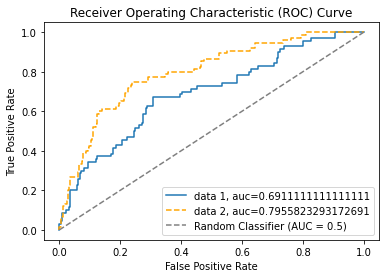

In [27]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming all_results is your DataFrame
y_test = all_results["unfavorable"]
y_pred_proba = all_results["y_pred_trafo_avg"]

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Plot the first ROC curve
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))

# Assuming all_results2 is your second DataFrame
y_test2 = all_results2["unfavorable"]
y_pred_proba2 = all_results2["y_pred_trafo_avg"]

fpr2, tpr2, _ = metrics.roc_curve(y_test2, y_pred_proba2)
auc2 = metrics.roc_auc_score(y_test2, y_pred_proba2)

# Plot the second ROC curve
plt.plot(fpr2, tpr2, label="data 2, auc="+str(auc2), linestyle='--', color='orange')

# Add the line for a random classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier (AUC = 0.5)')

# Customize the plot
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()
